In [27]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mp
import cell2location as cl
import seaborn as sb
import pandas as pd

mp.rcParams['pdf.fonttype'] = 42

In [28]:
outdir = 'immune'
# sample = 'DTA17'
sample = 'DTA23'
outdir_ref_sig = f'{outdir}/ref_signatures'
outdir_map = f'{outdir}/cell2location_map/{sample}'

In [29]:
ref_sig = pd.read_parquet(f'{outdir}/ref_signatures/ref_sig.pq')
ref_sig

,B1 cell,B cell,Capg+ Cd4+ T cell,Cd74+ C1q+ macrophage,Gngt2+ Cxcl2+ neutrophil,Gngt2+ Cxcl2- neutrophil,Gngt2- Cxcl2+ neutrophil,Gzmk+ Cd8+ T cell,Il4+ NK cell,Klra5+ Cd8+ T cell,Lef1+ Cd4+ T cell,Lef1+ Cd8+ T cell,Mpeg1-high macrophage,Ncr1+ NK cell,Neat1+ neutrophil,S100a6-high macrophage,hepatocyte
Sox17,0.795130,0.226049,0.608905,0.620421,0.003401,0.386082,0.018296,0.538686,0.671250,0.905312,0.761912,0.532440,0.850205,0.766162,0.614344,0.544734,0.596030
Mrpl15,2.273318,0.364170,0.747184,1.386135,0.164722,0.183181,0.018455,1.022844,1.432425,0.963238,0.310836,0.876928,0.191671,0.842834,0.031710,0.934806,2.766030
Lypla1,1.822877,0.226297,0.643665,1.087216,0.229655,0.212381,0.114911,0.811784,0.849015,0.519491,0.317307,0.460367,0.507851,0.616772,0.061054,1.036309,3.866681
Tcea1,3.092548,0.791119,1.693961,2.482394,0.263265,0.275805,0.070583,2.229983,2.010572,1.320716,0.893830,1.414940,0.692386,1.313819,0.100886,1.780907,1.673896
Atp6v1h,1.346831,0.277387,0.671701,1.424542,0.129934,0.155347,0.048995,0.765464,0.786784,0.544160,0.369535,0.451255,0.607078,0.515448,0.068372,1.075526,1.260340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Csprs,0.075710,0.010516,0.021612,0.021180,0.001872,0.003768,0.005533,0.035981,0.016744,0.016526,0.014358,0.005236,0.022988,0.006514,0.006732,0.005401,0.005247
Vamp7,1.061132,0.047568,0.258826,0.445582,0.010159,0.013577,0.011288,0.246593,0.410253,0.189537,0.097608,0.178753,0.165877,0.249783,0.006950,0.414932,0.783473
Tmlhe,0.014157,0.005632,0.094887,0.028995,0.000719,0.001109,0.000580,0.029203,0.123059,0.030211,0.094001,0.080340,0.025518,0.043344,0.002688,0.009484,0.284175
CAAA01147332.1,0.646239,0.027369,0.184332,0.381688,0.011701,0.006002,0.024216,0.258586,0.197345,0.113778,0.023239,0.062789,0.079364,0.185241,0.004309,0.275365,0.055488


In [30]:
# Prom1-DTA sample, A1 slide
adata_vis = sc.read_visium(f'../spaceranger/{sample}/outs')
adata_vis

/home/davids/local/miniconda3/envs/st/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3147 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [31]:
regions = pd.read_csv(
    f'../spaceranger/{sample}/outs/{sample}_region.csv',
    index_col = 'Barcode',
)
regions

,region
Barcode,
AAACAAGTATCTCCCA-1,fibrotic
AAACAATCTACTAGCA-1,paratumour
AAACACCAATAACTGC-1,necrotic
AAACAGAGCGACTCCT-1,fibrotic
AAACAGCTTTCAGAAG-1,paratumour
...,...
TTGTTGTGTGTCAAGA-1,tumour
TTGTTTCACATCCAGG-1,tumour
TTGTTTCATTAGTCTA-1,necrotic


In [32]:
# set up sample name
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

# add region annotations
adata_vis.obs = adata_vis.obs.join(regions, how='left')

adata_vis.obs

,in_tissue,array_row,array_col,sample,region
AAACAAGTATCTCCCA-1,1,50,102,DTA23,fibrotic
AAACAATCTACTAGCA-1,1,3,43,DTA23,paratumour
AAACACCAATAACTGC-1,1,59,19,DTA23,necrotic
AAACAGAGCGACTCCT-1,1,14,94,DTA23,fibrotic
AAACAGCTTTCAGAAG-1,1,43,9,DTA23,paratumour
...,...,...,...,...,...
TTGTTGTGTGTCAAGA-1,1,31,77,DTA23,tumour
TTGTTTCACATCCAGG-1,1,58,42,DTA23,tumour
TTGTTTCATTAGTCTA-1,1,60,30,DTA23,necrotic
TTGTTTCCATACAACT-1,1,45,27,DTA23,fibrotic


In [33]:
dup = adata_vis.var_names.duplicated()
adata_vis = adata_vis[:, ~dup].copy()

In [34]:
adata_vis.var.index.duplicated().sum()

0

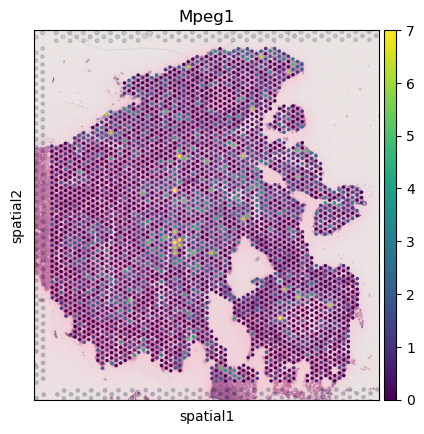

In [35]:
sc.pl.spatial(adata_vis, color='Mpeg1')

##### Remove mitochondria genes

In [36]:
is_mito = np.array([
    gene.startswith('mt-')
    for gene in adata_vis.var_names
])

# backup mitochondria gene expression
adata_vis.obsm['MT'] = adata_vis[:, is_mito].X.toarray()

# remove mitochondria genes
adata_vis = adata_vis[:, ~is_mito]

##### Subset common genes

In [37]:
genes = np.intersect1d(adata_vis.var_names, ref_sig.index)
len(genes)
pd.Series(genes).duplicated().sum()

0

In [38]:
adata_vis = adata_vis[:, genes].copy()
ref_sig = ref_sig.loc[genes, :].copy()

##### Model fitting

In [39]:
cl.models.Cell2location.setup_anndata(
    adata = adata_vis,
    batch_key = 'sample'
)

In [40]:
mod_cl = cl.models.Cell2location(
    adata_vis,
    cell_state_df = ref_sig,
    N_cells_per_location = 10,
    detection_alpha = 20
)
mod_cl.view_anndata_setup()

Anndata setup with scvi-tools version 0.19.0.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 3147  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 15178 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │   DTA23    │          0          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [41]:
mod_cl.train(
    max_epochs = 30000,
    batch_size = None,   # use full data
    train_size = 1,
    use_gpu = True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/davids/local/miniconda3/envs/st/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/davids/local/miniconda3/envs/st/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 475/30000:   2%|▏         | 474/30000 [01:14<1:17:54,  6.32it/s, v_num=1, elbo_train=2.03e+7]

In [ ]:
mod_cl.plot_history(1000)

In [ ]:
adata_vis = mod_cl.export_posterior(
    adata_vis,
    sample_kwargs = {
        'num_samples': 1000,
        'batch_size': mod_cl.adata.n_obs,
        'use_gpu': True
    }
)

In [ ]:
pl.axline((0, 0), slope=1, color='grey')
mod_cl.plot_QC()

In [ ]:
mod_cl.plot_spatial_QC_across_batches()
pl.show()

##### Add cell abundance annotation

In [ ]:
# add 5% quantile
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = \
    adata_vis.obsm['q05_cell_abundance_w_sf']

In [ ]:
mod_cl.save(outdir_map, overwrite=True)
adata_vis.write(f'{outdir_map}/{sample}.h5ad')

In [ ]:
# adata_vis = sc.read_h5ad(f'{outdir_map}/{sample}.h5ad')
# mod_cl = cl.models.Cell2location.load(outdir_map, adata_vis)

##### Visualize cell abundance in spatial coordinates

In [ ]:
slide = cl.utils.select_slide(adata_vis, sample)

# plot in spatial coordinates
with mp.rc_context(
        {
            'axes.facecolor': 'black',
            'figure.figsize': [7, 6]
        }
    ):
    sc.pl.spatial(slide,
        cmap = 'viridis',
        color = [
            'region', 'hepatocyte',
            'Mpeg1-high macrophage', 'S100a6-high macrophage',
            'Cd74+ C1q+ macrophage',
            'Lef1+ Cd8+ T cell', 'Lef1+ Cd4+ T cell',
            'Il4+ NK cell',
            'B cell',
        ],
        ncols = 1,
        vmin = 0, vmax = 'p99.2',
        show = False
    )
    pl.savefig(f'{outdir_map}/{sample}_sp_cell-abundance.pdf')
    pl.show()

In [ ]:
cell_types = [
    'hepatocyte', 'Mpeg1-high macrophage',
    'Lef1+ Cd8+ T cell',
    #'Lef1+ Cd4+ T cell',
]

with mp.rc_context(
        {
            'figure.figsize': (15, 15)
        }
    ):
    cl.plt.plot_spatial(
        adata = slide,
        color = cell_types,
        labels = cell_types,
        show_img = True,
        max_color_quantile = 0.992,
        circle_diameter = 6,
        colorbar_position = 'right',
    )
    pl.savefig(f'{outdir_map}/{sample}_sp_cell-abundance_joint.pdf')
    pl.show()